# Demo 12 - Probability and Missing Data

In this notebook we'll first take a look at what the effect of missing data can be on a classification mode, specifically using the Titanic dataset. Then we'll look at some ways of "fixing" that missing data, and the effect it has on the model.

In [1]:
# clone the course repository, change to right directory, and import libraries.
%cd /content
!git clone https://github.com/nmattei/cmps3160.git
%cd /content/cmps3160/_demos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
# SKLEARN stuff
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
# Load SQLITE
import sqlite3
plt.style.use('fivethirtyeight')
# Make the fonts a little bigger in our graphs.
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['pdf.fonttype'] = 42

/content
Cloning into 'cmps3160'...
remote: Enumerating objects: 1647, done.
remote: Counting objects: 100% (537/537), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 1647 (delta 319), reused 445 (delta 261), pack-reused 1110
Receiving objects: 100% (1647/1647), 45.27 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (920/920), done.
/content/cmps3160/_demos


In [2]:
# First let's load up the Titanic dataset and make a decision tree!
# We have a full datasheet here: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf
df_titanic = pd.read_csv("./data/titanic.csv")
df_titanic.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# We don't need a few of these -- Name, Cabin (why?) and home.dest so let's drop those
# body is the body id number, so that is only there for those that died, so let's drop it too, boat is life boat number
df_titanic.drop(columns=["name","cabin", "ticket","body","boat","home.dest"], inplace=True)
df_titanic.head(5)

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [4]:
df_titanic.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [5]:
# Let's do the easy part first: dummy out sex and embarked, dropna, and go to town.
df_ml = df_titanic.dropna()
df_ml = pd.get_dummies(df_ml, columns=["sex", "embarked"])
df_ml.head(5)

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,0,1
1,1,1,0.9167,1,2,151.5500,0,1,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,0,1
3,1,0,30.0000,1,2,151.5500,0,1,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,0,1


In [8]:
# Let's MACHINE LEARN!
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
def fit_and_report(df, features, target):
    train, test = train_test_split(df,
                               test_size=0.4,
                               stratify=df[target])
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    mod_dt = DecisionTreeClassifier(max_depth = 3, random_state = 1)
    mod_dt.fit(X_train,y_train)
    prediction=mod_dt.predict(X_test)
    ConfusionMatrixDisplay.from_estimator(mod_dt, X_test, y_test,
                                          display_labels=mod_dt.classes_,
                                          cmap=plt.cm.Blues, normalize='all')
    plt.figure(figsize = (15,8))
    plot_tree(mod_dt, feature_names = features, class_names={1:"survived", 0:"died"}, filled = True);

    print(f"The accuracy of the Decision Tree is {metrics.accuracy_score(prediction,y_test):.3f}")
    print(f"The Precision of the Decision Tree is {metrics.precision_score(prediction,y_test,average='weighted'):.3f}")
    print(f"The Recall of the Decision Tree is {metrics.recall_score(prediction,y_test,average='weighted'):.3f}")

The accuracy of the Decision Tree is 0.804
The Precision of the Decision Tree is 0.812
The Recall of the Decision Tree is 0.804


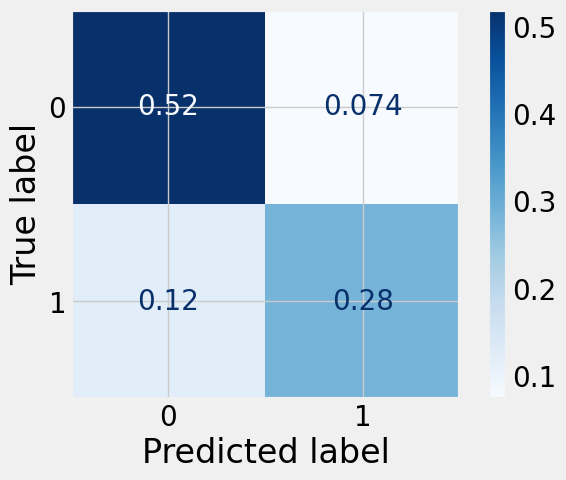

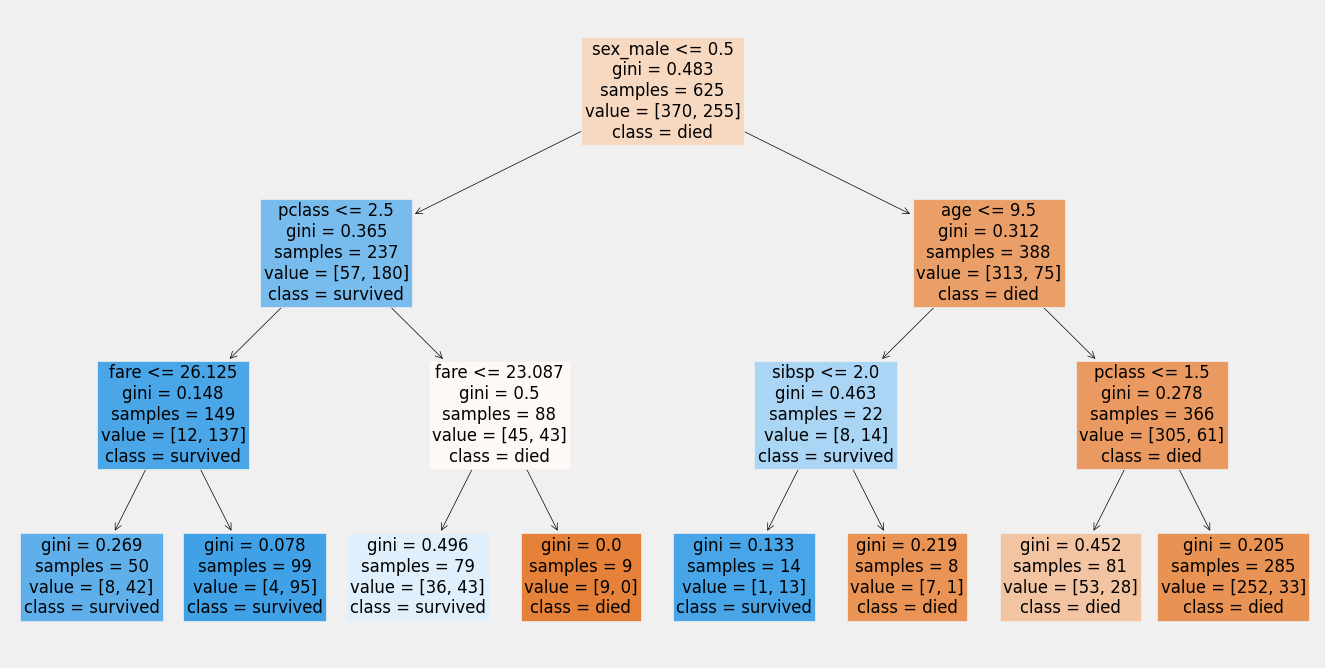

In [9]:
fit_and_report(df_ml,
                ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
                ["survived"])


In [10]:
# So we're doing pretty well... but let's see exactly what data is missing..

print(len(df_titanic))

print(len(df_titanic.dropna()))

print(len(df_titanic) - len(df_titanic.dropna()))


1309
1043
266


In [11]:
# But what are these features? What's missing? Is it important?
df_titanic[df_titanic.isnull().any(axis=1)]

,pclass,survived,sex,age,sibsp,parch,fare,embarked
15,1,0,male,NaN,0,0,25.9250,S
37,1,1,male,NaN,0,0,26.5500,S
40,1,0,male,NaN,0,0,39.6000,C
46,1,0,male,NaN,0,0,31.0000,S
59,1,1,female,NaN,0,0,27.7208,C
...,...,...,...,...,...,...,...,...
1293,3,0,male,NaN,0,0,8.0500,S
1297,3,0,male,NaN,0,0,7.2500,S
1302,3,0,male,NaN,0,0,7.2250,C
1303,3,0,male,NaN,0,0,14.4583,C


In [12]:
# So what kinds of folks are we dropping here?
df_titanic[df_titanic.isnull().any(axis=1)].describe()

,pclass,survived,age,sibsp,parch,fare
count,266.000000,266.000000,3.00000,266.000000,266.000000,265.000000
mean,2.631579,0.281955,53.50000,0.477444,0.240602,20.277483
std,0.736885,0.450800,13.44433,1.441127,0.944900,27.937708
min,1.000000,0.000000,38.00000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,49.25000,0.000000,0.000000,7.750000
50%,3.000000,0.000000,60.50000,0.000000,0.000000,8.050000
75%,3.000000,1.000000,61.25000,0.000000,0.000000,23.250000
max,3.000000,1.000000,62.00000,8.000000,9.000000,227.525000


In [13]:
# Where are they from?

print(df_titanic[df_titanic.isnull().any(axis=1)].embarked.value_counts())
print(df_titanic[df_titanic.isnull().any(axis=1)].pclass.value_counts())

S    133
Q     73
C     58
Name: embarked, dtype: int64
3    209
1     41
2     16
Name: pclass, dtype: int64


In [14]:
# So it looks like we're missing a ton of south hampton folks, that are in third class...
# Let's impute with the mean for the moment and see how our results change

df_ml_impute = df_titanic.fillna(df_titanic.mean(numeric_only=True))
df_ml_impute.head(5)

<ipython-input-14-5dd808416f6f>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_ml_impute = df_titanic.fillna(df_titanic.mean())


,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [15]:
df_ml_impute.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

In [16]:
df_ml_impute.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,12.883199,1.041658,0.865560,51.738879
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,29.881135,0.000000,0.000000,14.454200
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [17]:
# Okay, so now how many are we missing?
print(len(df_ml_impute) - len(df_ml_impute.dropna()))

# So we still have 2 missing
display(df_ml_impute[df_ml_impute.isnull().any(axis=1)])

2


,pclass,survived,sex,age,sibsp,parch,fare,embarked
168,1,1,female,38.0,0,0,80.0,NaN
284,1,1,female,62.0,0,0,80.0,NaN


The accuracy of the Decision Tree is 0.821
The Precision of the Decision Tree is 0.823
The Recall of the Decision Tree is 0.821


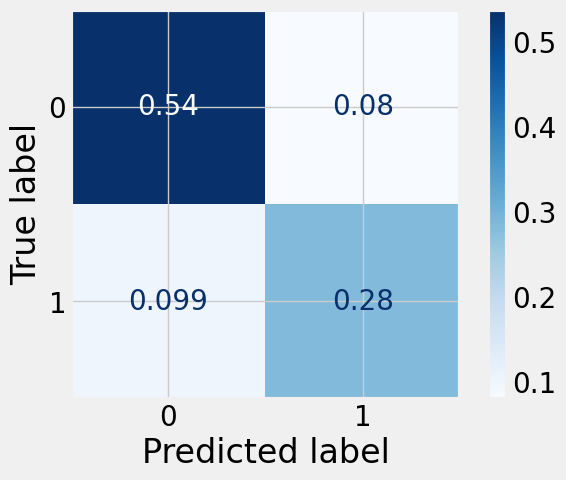

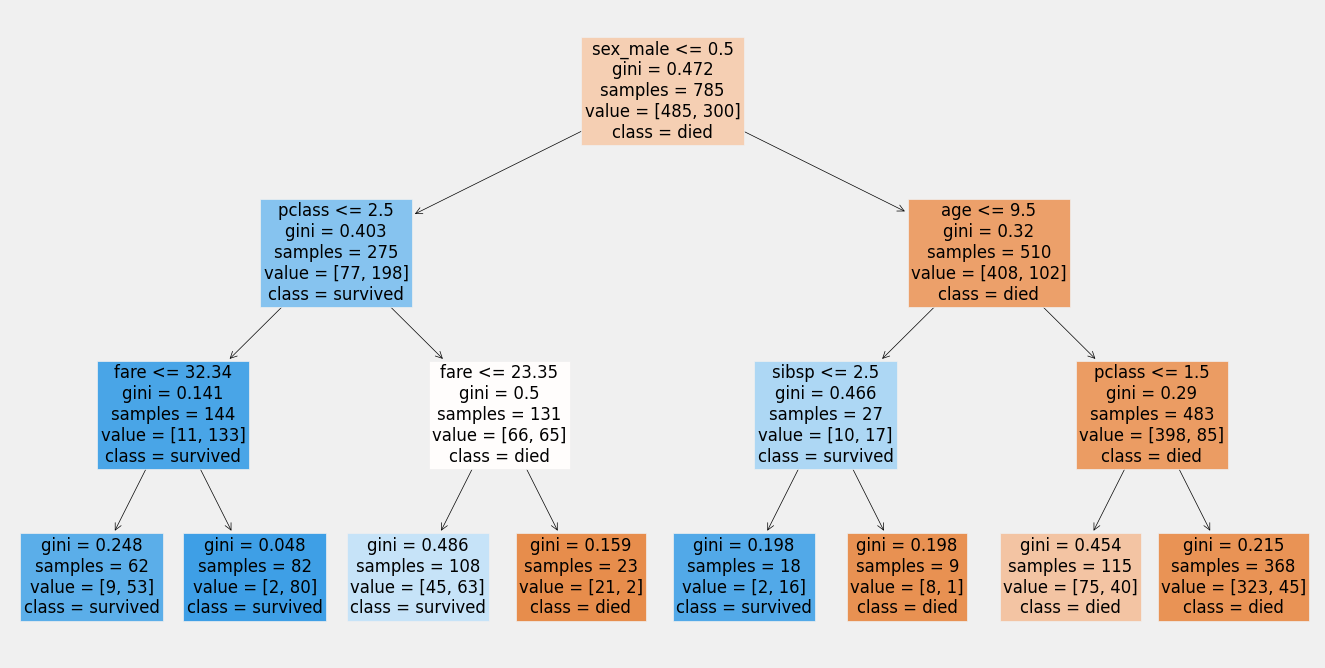

In [18]:
# Let Machine Learn again!
df_ml_impute = pd.get_dummies(df_ml_impute, columns=["sex", "embarked"])
fit_and_report(df_ml_impute,
                ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
                ["survived"])

In [19]:
df_titanic["age"].mean()

29.8811345124283

In [20]:
df_titanic["age"].median()

28.0

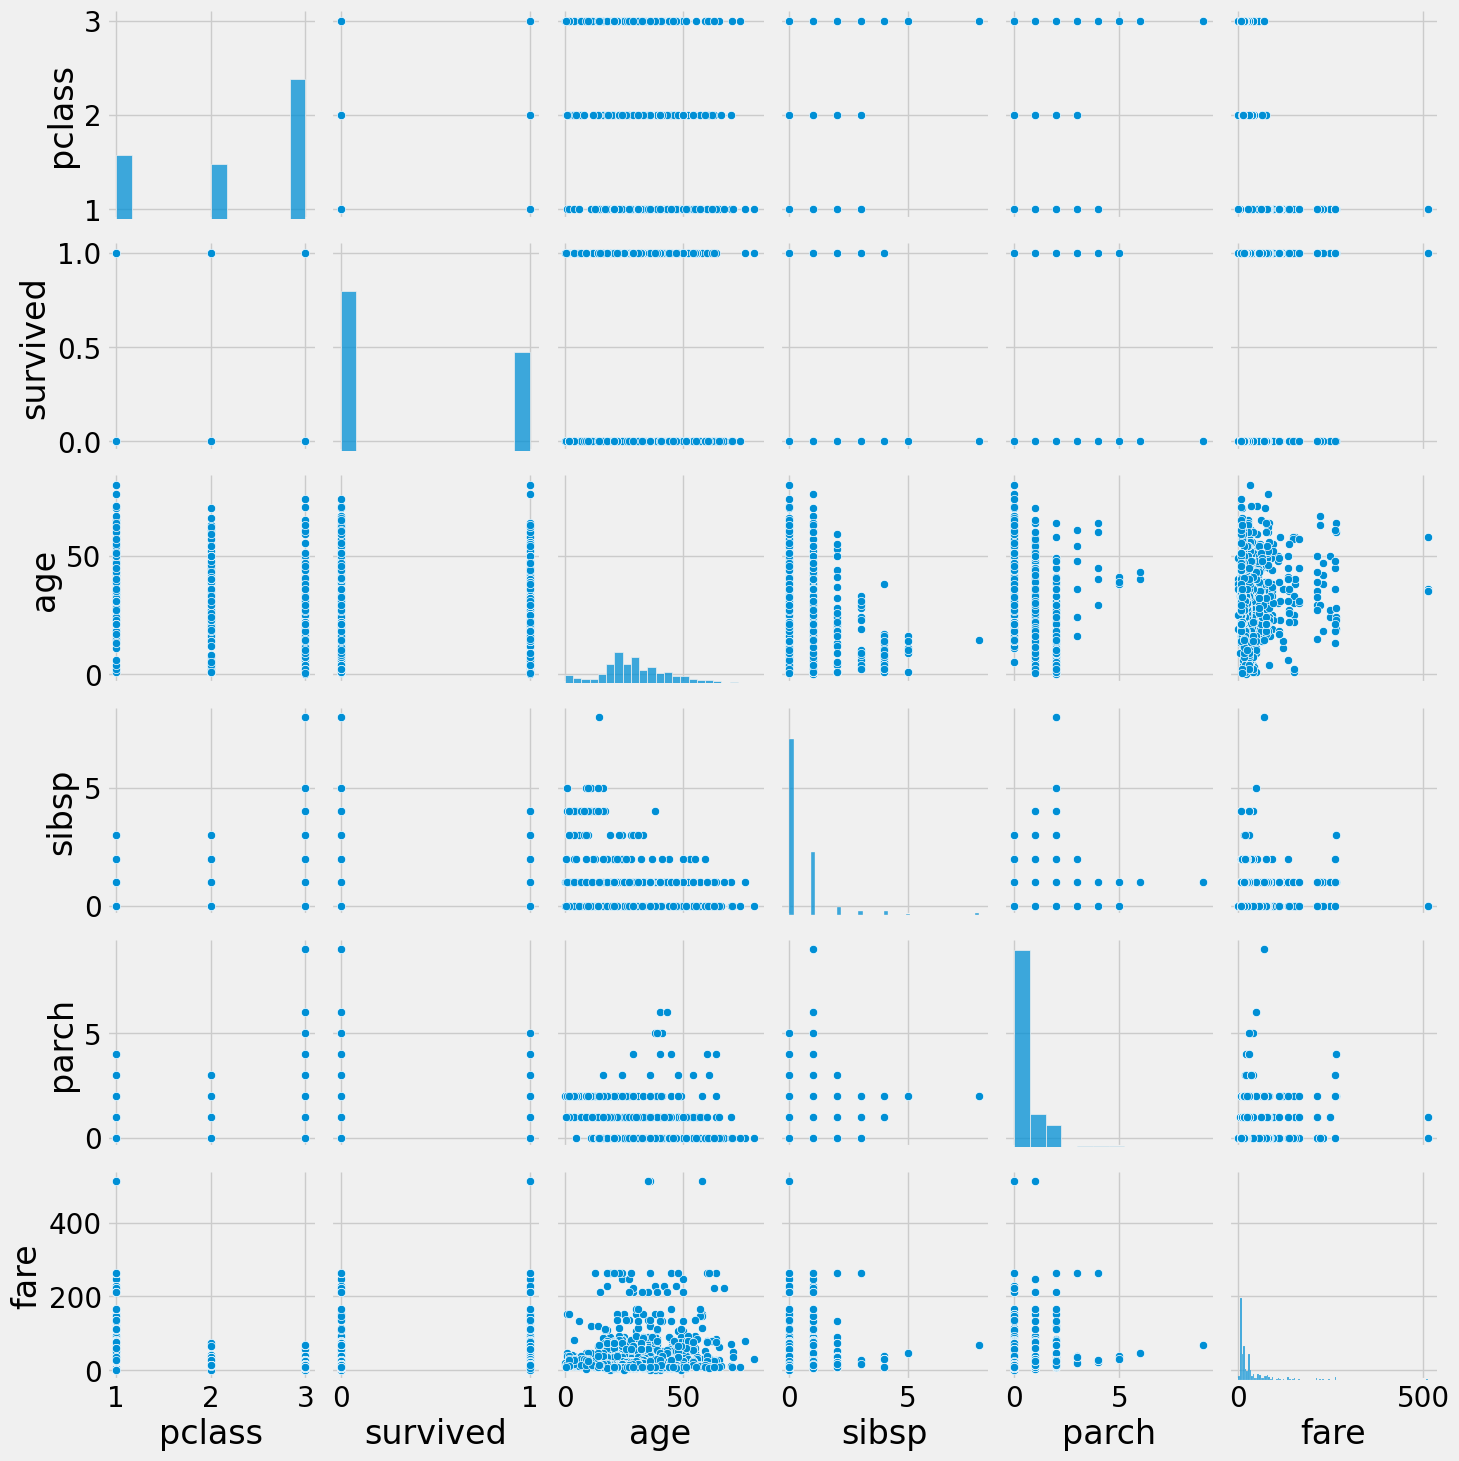

In [21]:
sns.pairplot(df_titanic)

In [22]:
df_titanic.groupby("sibsp").mean(numeric_only=True)

<ipython-input-22-0834e641ed3b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_titanic.groupby("sibsp").mean()


,pclass,survived,age,parch,fare
sibsp,,,,,
0,2.351291,0.346801,30.921776,0.181818,25.785406
1,2.034483,0.510972,31.058036,0.717868,48.711300
2,2.333333,0.452381,23.569444,0.571429,48.940576
3,2.550000,0.300000,16.312500,1.250000,71.332090
4,3.000000,0.136364,8.772727,1.545455,30.594318
5,3.000000,0.000000,10.166667,2.000000,46.900000
8,3.000000,0.000000,14.500000,2.000000,69.550000


## Part 2: The old Notebook

This first part is a copy of the missing data notebooks first...


In this notebook we will look at the effects missing data can have on conclusions you can draw from data.  We will also go over some practical implementations for linear regressions in Python

For this work we will be using data from: Generalized body composition prediction equation for men using simple measurement techniques", K.W. Penrose, A.G. Nelson, A.G. Fisher, FACSM, Human Performance research Center, Brigham Young University, Provo, Utah 84602 as listed in Medicine and Science in Sports and Exercise, vol. 17, no. 2, April 1985, p. 189.

[Data availabe here.](http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.html)

In [23]:
# Load the Penrose Data
df_penrose = pd.read_csv("./data/bodyfat.csv")

display(df_penrose.head())
# observations = ['Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist']
observations = ['Age', 'Neck', 'Forearm', 'Wrist']

len(df_penrose)

,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


252

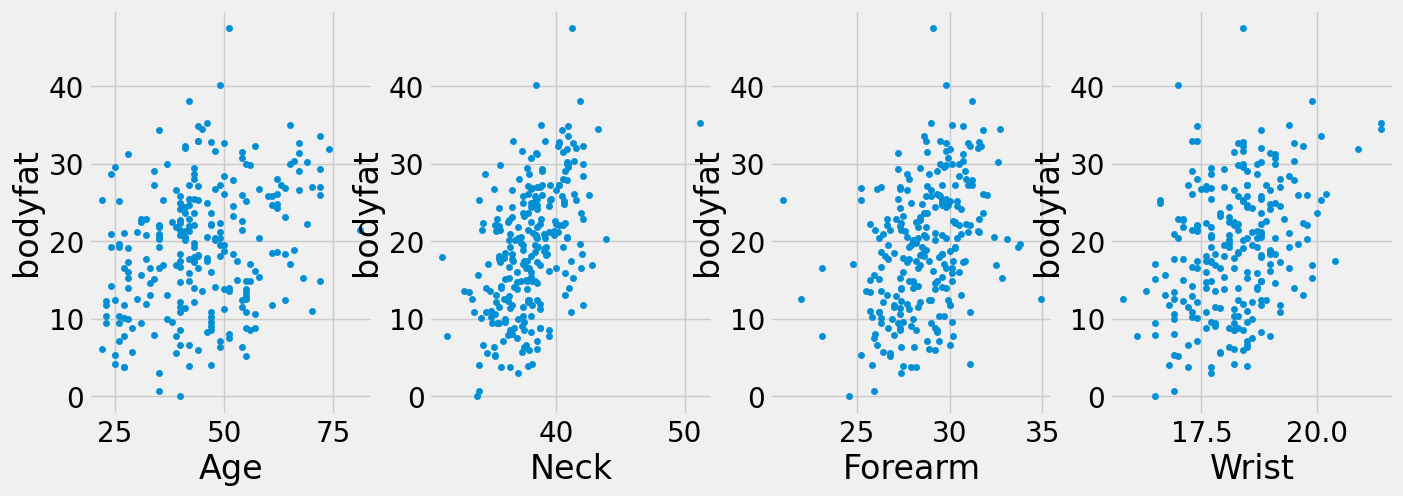

In [24]:
# Let's do some really basic scatter plotting...

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

Let's say we want to look at some linear regressions of single variables to see what is going on!  So let's plot some regression lines.  Note that there are at least a few different ways -- [linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html), [polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html), and [statsmodels](https://www.statsmodels.org/stable/index.html).

Here's a good article about it [Data science with Python: 8 ways to do linear regression and measure their speed](https://www.freecodecamp.org/news/data-science-with-python-8-ways-to-do-linear-regression-and-measure-their-speed-b5577d75f8b/).

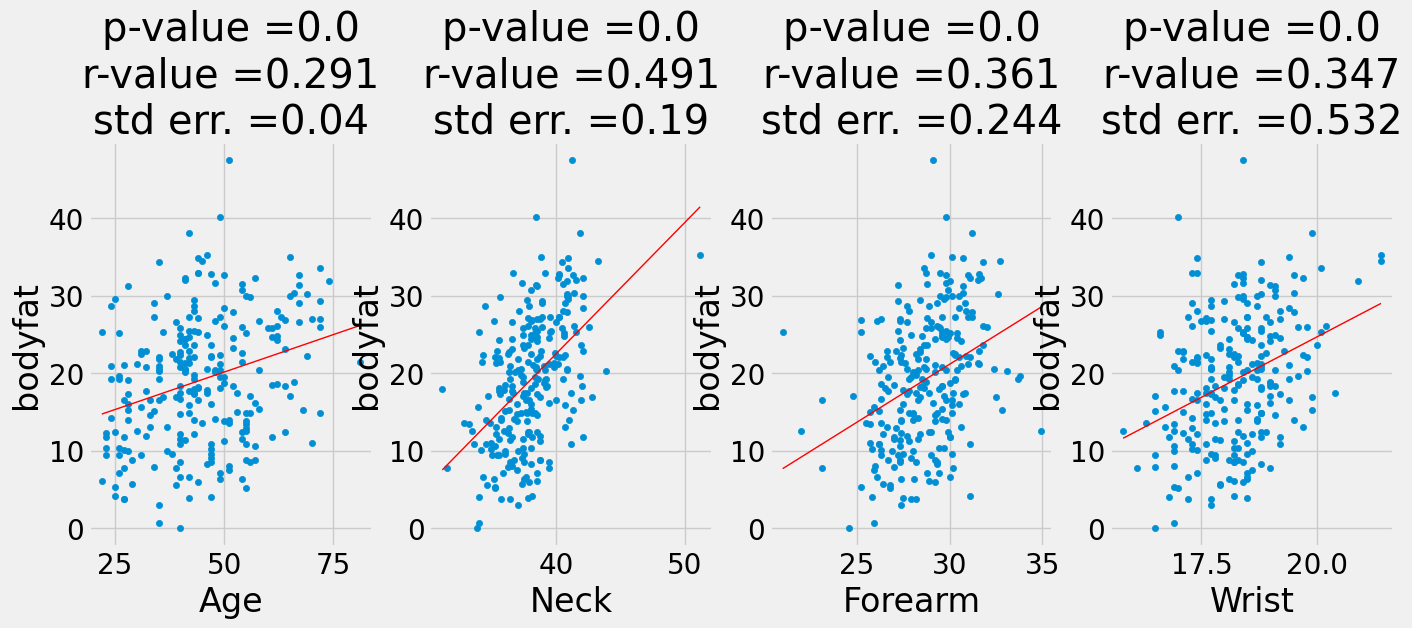

In [28]:
# Let's do a basic Linear Regression on a Single Variable.
# Note that linregress p-value is whether or not the slope is 0, not if the correlation is significant.
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_penrose[o],
                                                                   df_penrose['bodyfat'])

    # Pack these into a nice title
    diag_str = "p-value =" + str(round(p_value, 3)) + "\n" + "r-value =" + str(round(r_value, 3)) + "\nstd err. =" + str(round(std_err, 3))
    df_penrose.plot.scatter(x=o, y='bodyfat', title=diag_str, ax=ax[i])

    # Make points and line
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')


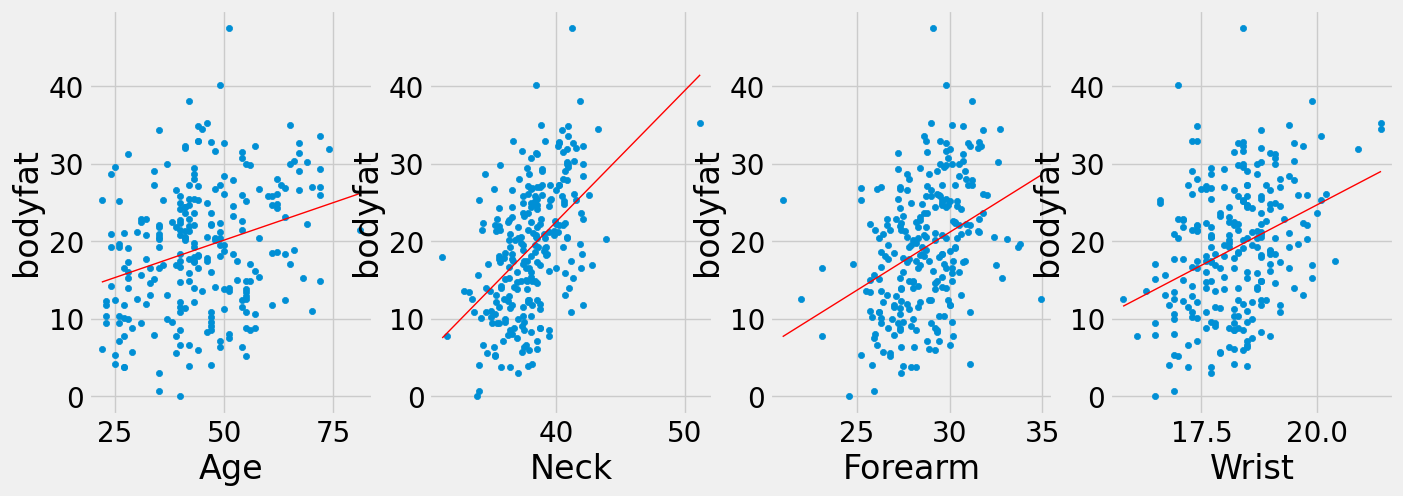

In [26]:
# We could also use the polyfit function

# Let's try to fit a linear model with PolyFit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    # Fit our curve
    x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 1)

    # Plot regular points
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

    # Plot curve
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

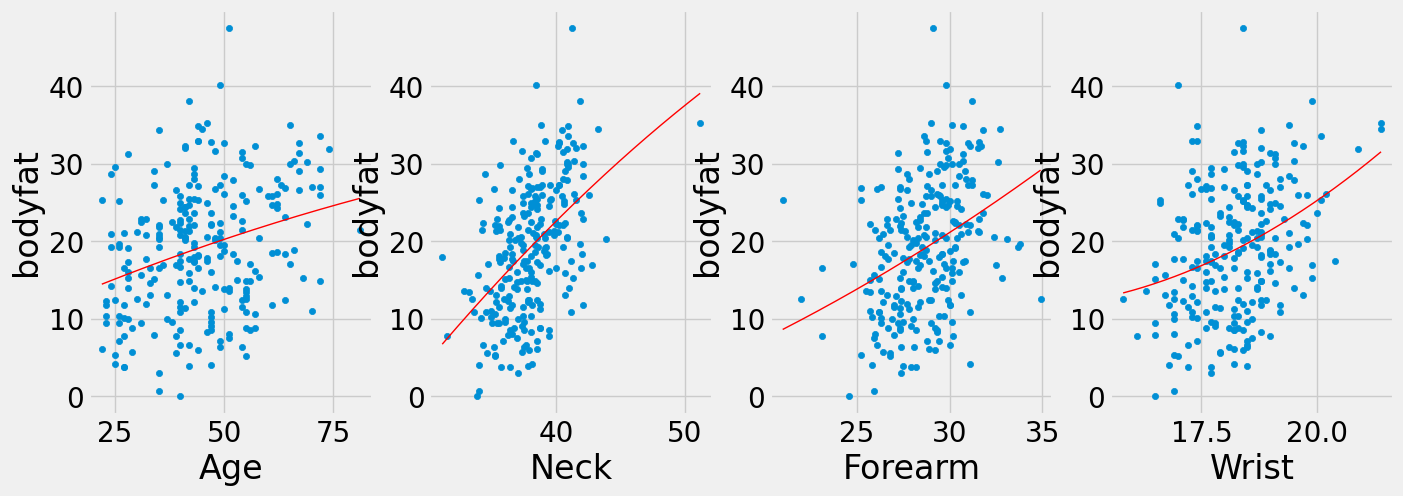

In [27]:
# Let's try fitting a degree 2 polynomial with polyfit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):

    # Fit the polynomial.
    x2, x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 2)

    # Plot our points.
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

    # Plot the Regression Line..
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x2 * pts**2 + x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

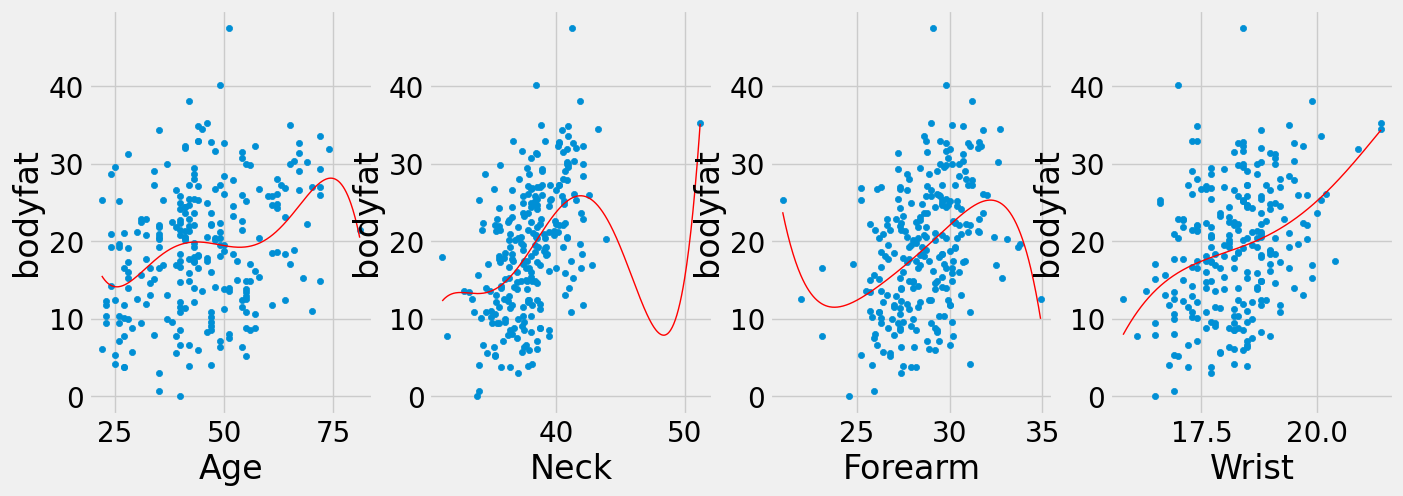

In [29]:
# Let's try fitting a degree 5 polynomial with polyfit.

fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):

    # Fit the polynomial.
    x5, x4, x3, x2, x1, intercept = np.polyfit(df_penrose[o],df_penrose['bodyfat'], 5)

    # Plot our points.
    df_penrose.plot.scatter(x=o, y='bodyfat', ax=ax[i])

    # Plot the Regression Line..
    pts = np.linspace(df_penrose[o].min(), df_penrose[o].max(), 500)
    line = x5 * pts**5 + x4 * pts**4 + x3 * pts**3 + x2 * pts**2 + x1 * pts + intercept
    ax[i].plot(pts, line, lw=1, ls='-', color='red')

### A More Complicated example with Statsmodels.

Statsmodels (you'll likely need to install it) gives a much more R-like interface to linear modeling.  You can read [more about it here](https://www.statsmodels.org/stable/index.html).

In [30]:
import statsmodels.api as sm
df_ind = df_penrose[['Neck', 'Wrist']]
df_target = df_penrose['bodyfat']

In [31]:
X = df_ind
y = df_target

# Note the difference in argument order
# Call: endog, then exog (dependent, indepenednt)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model
# Print out the statistics
model.summary()
#fig, ax = plt.subplots(figsize=(12,8))
#fig = sm.graphics.plot_partregress(endog="bodyfat", exog_i=['Abdomen', 'Neck'], exog_others='', data=df_penrose)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                bodyfat   R-squared (uncentered):                   0.868
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                              823.5
Date:                Sat, 05 Aug 2023   Prob (F-statistic):                   9.64e-111
Time:                        16:29:20   Log-Likelihood:                         -868.15
No. Observations:                 252   AIC:                                      1740.
Df Residuals:                     250   BIC:                                      1747.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Neck           1.6874      0.295      5.714      0.000       1.106       2.269
Wrist         -2.4602      0.616     -3.995      0.000      -3.673      -1.247
==============================================================================
Omnibus:                        2.850   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.309
Skew:                           0.107   Prob(JB):                        0.315
Kurtosis:                       2.583   Cond. No.                         60.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also use the [single regressor plot](https://tedboy.github.io/statsmodels_doc/generated/statsmodels.graphics.api.plot_partregress.html#statsmodels.graphics.api.plot_partregress).

eval_env: 1


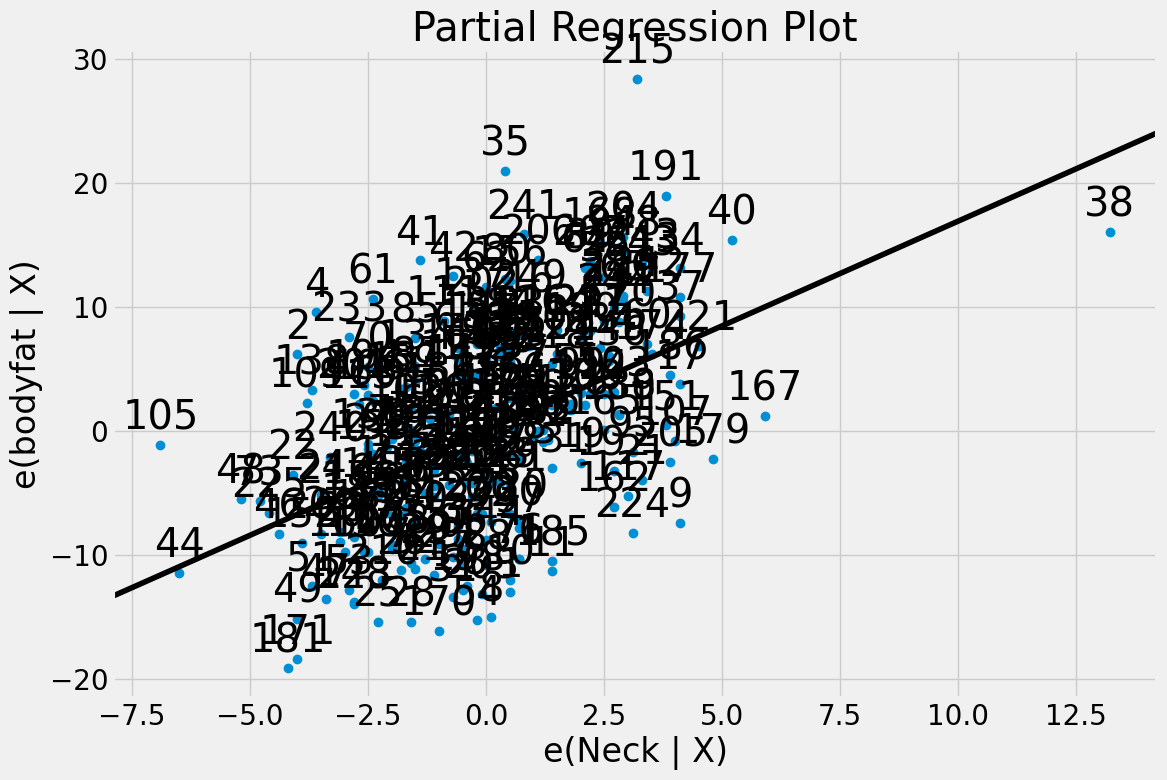

In [32]:
from statsmodels.graphics.regressionplots import plot_partregress
fig, ax = plt.subplots(figsize=(12,8))
plot_partregress(endog='bodyfat', exog_i='Neck', exog_others='', data=df_penrose, ax=ax)
plt.show()

If we have multiple elements in our regression then we need to use a different plot.

eval_env: 1
eval_env: 1


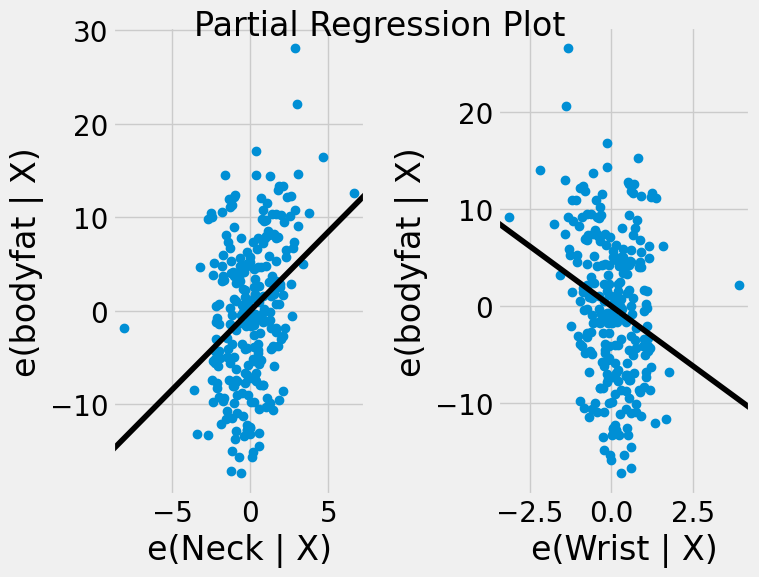

In [33]:
# Multiple regression plot
from statsmodels.graphics.regressionplots import plot_partregress_grid
fig = plt.figure(figsize=(8, 6))
plot_partregress_grid(model, fig=fig)
plt.show()

Another way to work with regressions and their plots is using the [Seaborn Regression Package](https://seaborn.pydata.org/tutorial/regression.html)

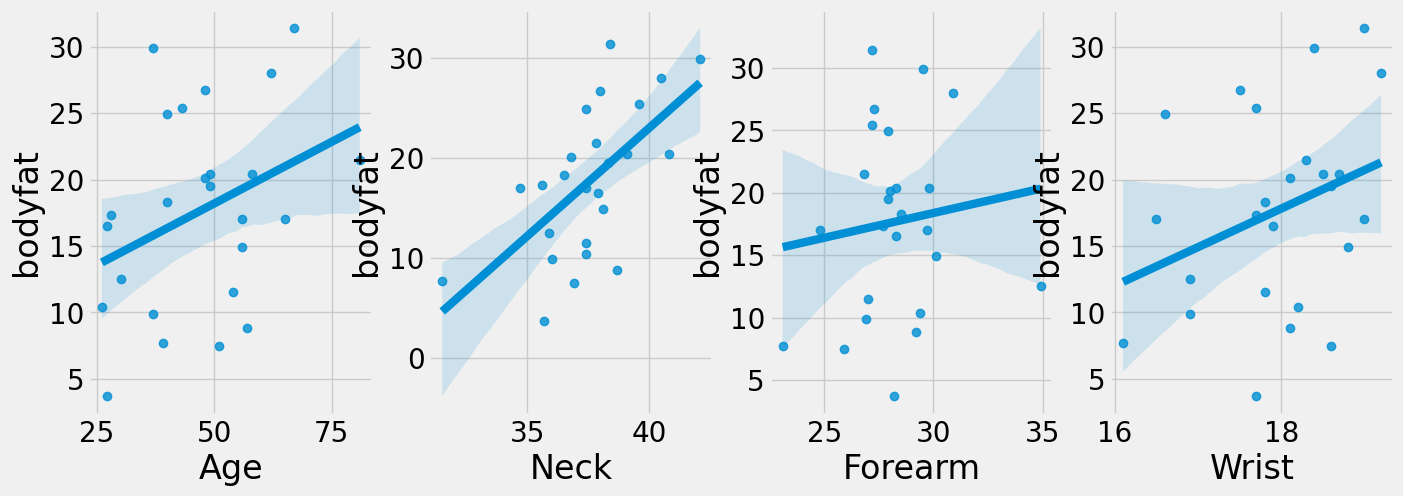

In [34]:
# Another way to do simple exploratory plots
import seaborn as sns
df_test = df_penrose.sample(frac=0.10, replace=False)
fig, ax = plt.subplots(1, 4, figsize=(15,5))

for i,o in enumerate(observations):
    sns.regplot(x=o, y='bodyfat', data=df_test, ax=ax[i])
    #g.axes.set_xlim(df_test[o].min()*.95,df_test[o].max()*1.05)

Another nice simulator to play with is [this one](https://ndirienzo.shinyapps.io/linear_regression_sim/) which is from [Prof. Nicholas DiRienzo](https://ischool.arizona.edu/people/nicholas-dirienzo) from ASU's School of Information

## Logistic Regression

We can use sklearn to do a quick logistic regression.  Remember that for logistic regression we are testing whether or not something is true, so we need to add a variable to our data.

Someone is obese if their body fat is >32% so we'll add a dummy for that!

In [35]:
df_penrose['obese'] = df_penrose.apply(lambda x: 1 if x['bodyfat'] > 32 else 0, axis=1)

In [36]:
df_penrose.head(5)

,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,obese
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,0
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,0
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,0
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,0
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,0


In [37]:
# We're going to use sklearn to build us a classifier.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# setup our data for testing and training.

X_train, X_test, y_train, y_test = train_test_split(df_penrose[observations],
                                                    df_penrose['obese'],
                                                    test_size=0.2)


In [38]:
X_train[:10]

,Age,Neck,Forearm,Wrist
79,66,37.4,28.7,19.0
135,44,37.8,28.8,17.6
104,43,39.6,27.2,17.7
27,31,38.8,26.6,17.0
242,66,41.4,30.7,19.5
134,41,36.5,29.8,18.1
236,62,40.6,28.5,19.0
204,44,40.9,30.7,17.4
58,54,40.5,28.8,18.2
18,28,38.0,30.5,18.5


In [39]:
# Fit that model!
logisticRegr = LogisticRegression(max_iter=100000, class_weight='balanced')
model = logisticRegr.fit(X_train, y_train)

Accuracy Score is: 0.7843137254901961


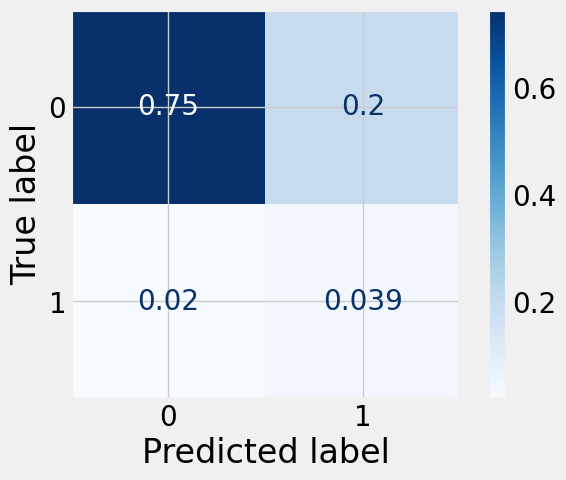

In [41]:
# Fit and plot!
y_pred = model.predict(X_test)
print(f"Accuracy Score is: {accuracy_score(y_test, y_pred)}")
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                          display_labels=model.classes_,
                                          cmap=plt.cm.Blues, normalize='all')


# Now back to Missing Data!!

What happens if we start to remove parts of the data -- is the relationship still as strong?

We can use the [pandas sample command](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) to remove some of the dataframe.

Note that here we are just asking the question, if we took some of the data out randomly, do we still get the same result?

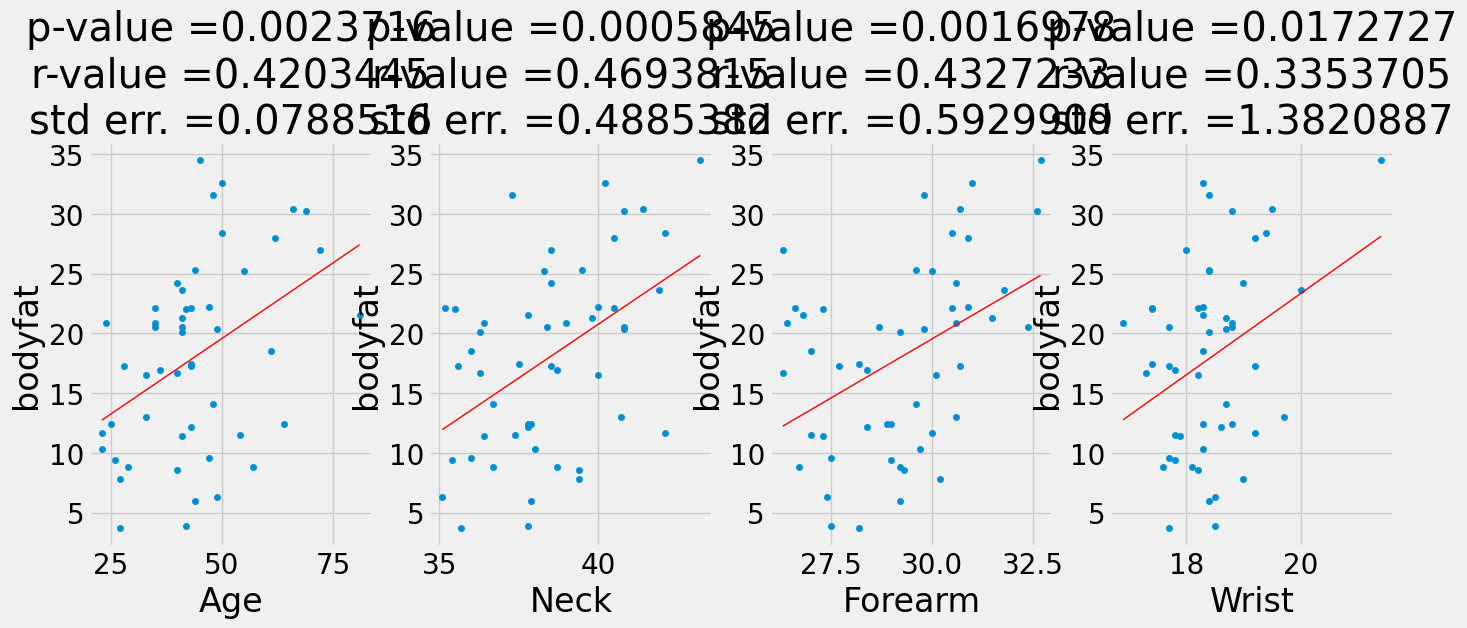

In [42]:
# Let's do a basic Linear Regression on a Single Variable.
# Note that linregress p-value for the null-hyp that slope = 0.
df_test = df_penrose.sample(frac=0.2, replace=False)

fig, ax = plt.subplots(1, 4, figsize=(15,5))
for i,o in enumerate(observations):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_test[o],
                                                                   df_test['bodyfat'])

    # Pack these into a nice title
    diag_str = "p-value =" + str(round(p_value, 7)) + "\n" + "r-value =" + str(round(r_value, 7)) + "\nstd err. =" + str(round(std_err, 7))
    df_test.plot.scatter(x=o, y='bodyfat', title=diag_str, ax=ax[i])

    # Make points and line
    pts = np.linspace(df_test[o].min(), df_test[o].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')

If we want to determine if these correlations are significant under the missing data then we need to run bootstrap samples and see what happens.

Nick -- modify this to drop part of the data then resample from the dropped part!

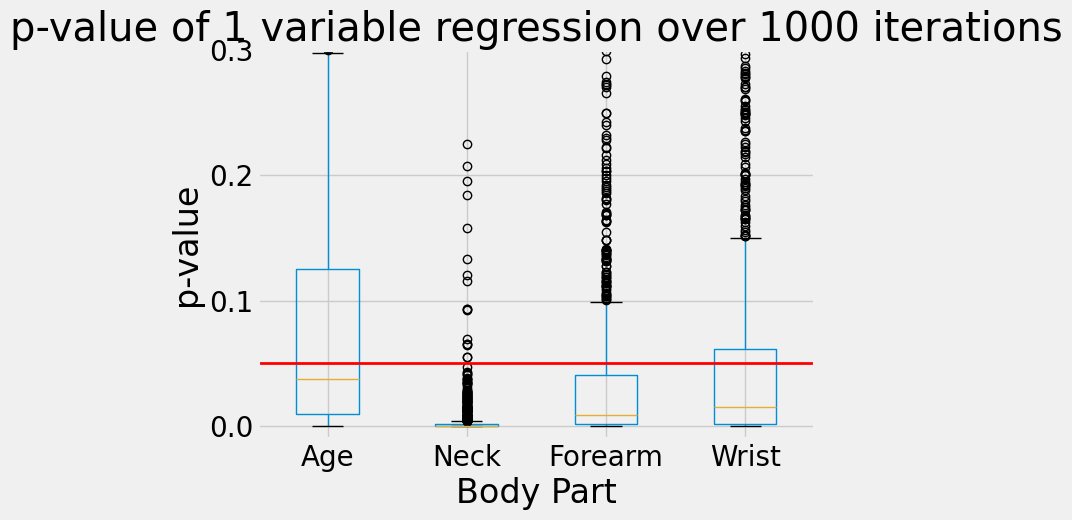

In [43]:
results = {o:[] for o in observations}
bootstrap_samples = 1000
fraction = 0.20

for i,o in enumerate(observations):
    for t in range(bootstrap_samples):
        df_test = df_penrose.sample(frac=fraction, replace=False)
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_test[o],df_test['bodyfat'])
        #r,p = stats.pearsonr(df_test[o], df_test['bodyfat'])
        results[o].append(p_value)

rs = pd.DataFrame(results)
ax = rs.boxplot()
ax.set_ylim([-0.01,0.30])
ax.set_title(f"p-value of 1 variable regression over {bootstrap_samples} iterations")
ax.set_ylabel("p-value")
ax.set_xlabel("Body Part")
ax.axhline(y=0.05, lw=2, color='red')
plt.show()

As we can see above as we run more and more samples and plot the p-values

# 11 - Probability and Simulation

In this notebook we look at some fun ways to do sampling and test some of the basics of probability just for giggles.

## Probability and Code!

Note we're using [Numpy's probability functions](https://numpy.org/doc/stable/reference/random/index.html), you could also use [Python's](https://docs.python.org/3/library/random.html)

In [45]:
# Let's make a probability distribution:
outcomes = list(range(1,7))
outcomes

[1, 2, 3, 4, 5, 6]

In [46]:
#Simulate an outcome..
np.random.choice(outcomes)

3

In [47]:
# Do it a lot...
np.random.choice(outcomes, 20)

array([5, 6, 3, 5, 3, 6, 6, 6, 6, 1, 4, 6, 6, 4, 5, 5, 1, 5, 5, 4])

<Axes: ylabel='Frequency'>

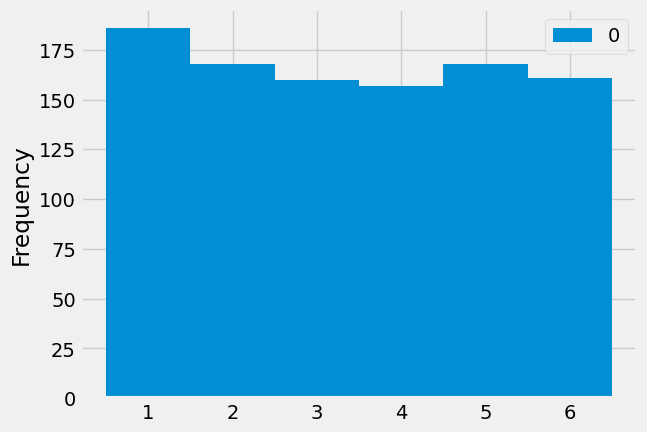

In [48]:
# Graph it!
results = pd.DataFrame(np.random.choice(outcomes, 1000))
results.plot.hist(bins=np.arange(0.5,7.5, 1))

<Axes: ylabel='Frequency'>

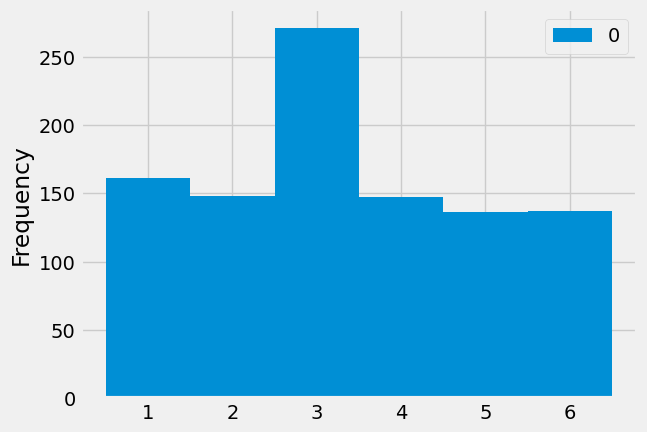

In [49]:
# Do it with a biased coin..
b = 1.0 / 7.0
b1 = 2.0 / 7.0
results = pd.DataFrame(np.random.choice(outcomes, 1000, p=[b, b, b1, b, b, b]))
results.plot.hist(bins=np.arange(0.5,7.5, 1))

In [50]:
# Do it for multiple events!
die1 = np.random.choice(outcomes, 10000)
die2 = np.random.choice(outcomes, 10000)
results = pd.DataFrame({'Die1': die1, 'Die2':die2})
results.head()

,Die1,Die2
0,1,4
1,3,5
2,2,3
3,6,5
4,1,2


<Axes: ylabel='Frequency'>

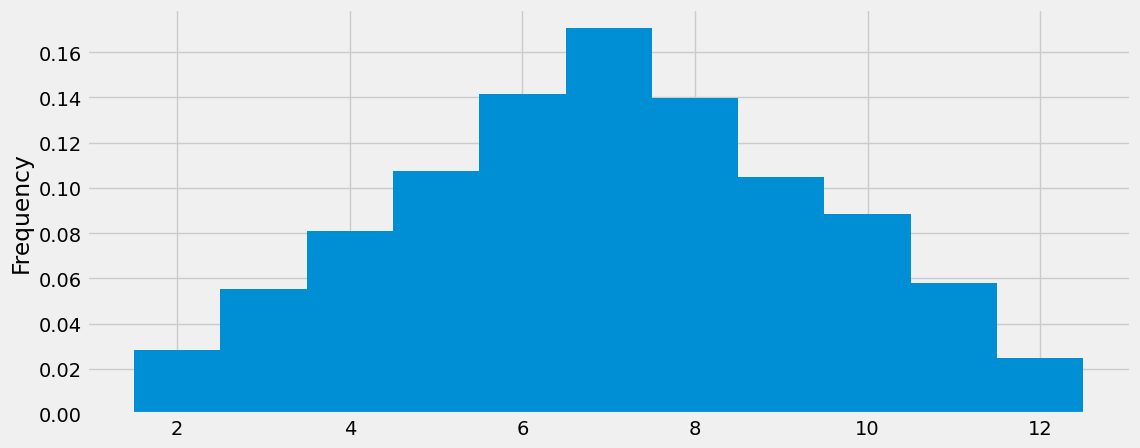

In [51]:
# Need to add them up...
plt.figure(figsize = (12,5))
results['sum'] = results["Die1"] + results["Die2"]
results['sum'].plot.hist(bins=np.arange(1.5, 13.5, 1), density=True)

In [52]:
# Default is with replacement but we can do without replacement..
people = ['Winona', 'Xanthippe', 'Yvonne', 'Zelda']
np.random.choice(people, 3, replace=False)

array(['Winona', 'Yvonne', 'Zelda'], dtype='<U9')

### One thing we may want to do in a stats model is ....

See if a particular distribution is the same as some known distribution. To do this we typically use the [Chi Squared test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) if we known the underlying distribution.

Here we know that rolling two dice and summing them **should** give us a normal distribution so we can use a more complex [normal test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html) from Pearson (of correlation coefficient fame) to check...

**Returns**

statistic : float or array
s^2 + k^2, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest.

pvalue: float or array
A 2-sided chi squared probability for the hypothesis test.

In [53]:
# See if one die is really a uniform distribution.
#
# Note that we need: f_obsarray_like
#                    Observed frequencies in each category.
#                    f_exparray_like, optional
#Expected frequencies in each category. By default the categories are assumed to be equally likely.
#

from scipy import stats
chisq, p = stats.chisquare(results["Die1"].value_counts())
print("ChiSq = {} and p = {}".format(chisq,p))

ValueError: ignored

In [54]:
# See if the sum is normal..

from scipy import stats
k2, p = stats.normaltest(results["sum"])
print("K2 = {} and p = {}".format(k2,p))

K2 = 374.21802136912277 and p = 5.49021238711297e-82


What could things like this be used for when building statistical models? [Hint!](http://data8.org/materials-sp18/lec/lec16PDF.pdf)

## Looking at Two Variables.

Let's roll two dice a bunch of times and see the resutls.


In [55]:
die1 = np.random.choice(outcomes, 100)
die2 = np.random.choice(outcomes, 100)
results = pd.DataFrame({'Die1': die1, 'Die2':die2})

In [56]:
counts = pd.crosstab(results['Die1'], results['Die2'])
counts

Die2,1,2,3,4,5,6
Die1,,,,,,
1,3,3,2,4,3,4
2,3,3,1,2,2,3
3,2,6,3,1,2,1
4,6,4,0,3,5,2
5,2,3,2,1,3,2
6,3,4,2,2,5,3


In [57]:
joint = pd.crosstab(results['Die1'], results['Die2'], normalize=True)
joint

Die2,1,2,3,4,5,6
Die1,,,,,,
1,0.03,0.03,0.02,0.04,0.03,0.04
2,0.03,0.03,0.01,0.02,0.02,0.03
3,0.02,0.06,0.03,0.01,0.02,0.01
4,0.06,0.04,0.00,0.03,0.05,0.02
5,0.02,0.03,0.02,0.01,0.03,0.02
6,0.03,0.04,0.02,0.02,0.05,0.03


In [58]:
# Now we can roll this up for either die to see it's distribution
joint.sum(axis=0)

Die2
1   0.19
2   0.23
3   0.10
4   0.13
5   0.20
6   0.15
dtype: float64

In [59]:
# Can also get marginals directly.
marginals = pd.crosstab(results['Die1'], results['Die2'], normalize=True, margins=True)
marginals

Die2,1,2,3,4,5,6,All
Die1,,,,,,,
1,0.03,0.03,0.02,0.04,0.03,0.04,0.19
2,0.03,0.03,0.01,0.02,0.02,0.03,0.14
3,0.02,0.06,0.03,0.01,0.02,0.01,0.15
4,0.06,0.04,0.00,0.03,0.05,0.02,0.20
5,0.02,0.03,0.02,0.01,0.03,0.02,0.13
6,0.03,0.04,0.02,0.02,0.05,0.03,0.19
All,0.19,0.23,0.10,0.13,0.20,0.15,1.00


In [60]:
# Finally, if we want conditional distributions we have to do a bit of work. Let's try to work out
# P(Die 1 is a 6 | Die 2 is a 5)

counts = pd.crosstab(results['Die1'], results['Die2'])
counts

Die2,1,2,3,4,5,6
Die1,,,,,,
1,3,3,2,4,3,4
2,3,3,1,2,2,3
3,2,6,3,1,2,1
4,6,4,0,3,5,2
5,2,3,2,1,3,2
6,3,4,2,2,5,3


In [61]:
# We need to get the (Die 2 is a 5 row) and then look at the distribution there..

counts[5] / counts[5].sum()

Die1
1   0.15
2   0.10
3   0.10
4   0.25
5   0.15
6   0.25
Name: 5, dtype: float64

## Using Simulation to Answer Probability Questions.

In CMPS 2170 we figured out closed form formulas for a set of mutually independent Bernoilli Trials.

* Bernoulli Trial: an experiment with two possible outcomes
* E.g., flip a coin results in two possible outcomes: head (𝐻) and tail (𝑇)
* Independent Bernoulli Trials: a sequence of Bernoulli trails that are mutually independent

* Example: What is the probability of the sequence HHHTT for a coin flip sequence with $p$ for H and $1-p$ for T?
  * $p^3(1-p)^2$.

Recall: The probability of exactly $k$ successes in $n$ independent Bernoulli trials, with probability of success $p$ and probability of failure $q = 1 − p$, is $C(n,k)p^kq^{n-k}$ where $C(n,k)$ is $n$ choose $k$.

In [62]:
# Setup a biased coin and flip it a bunch..
coin_results = np.random.choice(["Heads", "Tails"], 100, p=[0.75, 0.25])
coin_results

array(['Heads', 'Heads', 'Heads', 'Heads', 'Heads', 'Tails', 'Heads',
       'Heads', 'Tails', 'Heads', 'Tails', 'Heads', 'Heads', 'Heads',
       'Heads', 'Tails', 'Heads', 'Tails', 'Heads', 'Tails', 'Heads',
       'Heads', 'Tails', 'Heads', 'Heads', 'Heads', 'Heads', 'Heads',
       'Heads', 'Heads', 'Heads', 'Heads', 'Tails', 'Heads', 'Heads',
       'Tails', 'Heads', 'Tails', 'Heads', 'Heads', 'Heads', 'Heads',
       'Tails', 'Tails', 'Tails', 'Heads', 'Heads', 'Heads', 'Heads',
       'Heads', 'Heads', 'Heads', 'Tails', 'Heads', 'Heads', 'Heads',
       'Heads', 'Tails', 'Tails', 'Heads', 'Heads', 'Heads', 'Tails',
       'Heads', 'Heads', 'Heads', 'Heads', 'Heads', 'Tails', 'Tails',
       'Heads', 'Heads', 'Tails', 'Tails', 'Heads', 'Heads', 'Tails',
       'Heads', 'Tails', 'Heads', 'Tails', 'Heads', 'Tails', 'Heads',
       'Tails', 'Heads', 'Heads', 'Heads', 'Heads', 'Tails', 'Heads',
       'Heads', 'Tails', 'Heads', 'Heads', 'Heads', 'Heads', 'Heads',
       'Tails', 'Hea

## A More complex Question..

* What is the probability of getting 60 or more heads if I flip 100 coins?
* Approximation through simulation:
  1. Figure out how to do one experiment (i.e., flip 100 coins).
  2. Run the experiment a bunch of times.
  3. Find the fraction of times where number of heads >= 60.

In [63]:
# Flip 100 coins and count heads...
coin_results = np.random.choice(["Heads", "Tails"], 100, p=[0.75, 0.25])
print(coin_results == 'Heads')
print(np.count_nonzero(coin_results == 'Heads'))


[ True  True False  True  True  True False  True  True  True False  True
 False  True False  True  True False False  True  True False False False
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True False  True False False  True  True  True
 False  True  True  True False False  True  True  True False False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True False  True False  True  True  True  True False False  True  True
 False  True False  True  True  True  True False False  True  True  True
  True  True False  True]
70


In [64]:
# Wrap it up and do it a bunch...
# Note we're using Numpy here for broadcasting -- numpy arrays are imuteable so
# it's a tad more akaward in places..
n_reps = 10000

def exp():
    coin_results = np.random.choice(["Heads", "Tails"], 100, p=[0.50, 0.50])
    return np.count_nonzero(coin_results == 'Heads')

head_counts = np.array([])
for i in range(n_reps):
    head_counts = np.append(head_counts, exp())

In [65]:
# Figure it out...
print(np.count_nonzero(head_counts >= 60))
print(np.count_nonzero(head_counts >= 60) / n_reps)

283
0.0283


If we work out the math we need at least 60 H so we have to add up quite a few things...
$\sum^{100}_{k=60} C(100, k)p^kq^n-k$

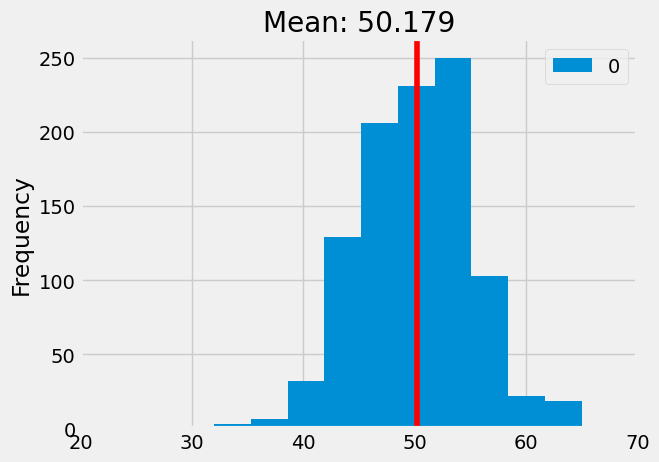

In [66]:
# Using simiulation we can also look at the trials
n_reps = 1000

head_counts = np.array([])
for i in range(n_reps):
    head_counts = np.append(head_counts, exp())

results = pd.DataFrame(head_counts)
ax = results.plot.hist()
plt.xlim(20,70)
plt.axvline(np.mean(head_counts), color='red')
plt.title(f"Mean: {np.mean(head_counts)}")
plt.show()

## Settle the Monty Hall Thing...

In [67]:
def simulate_monty_hall():
    behind_picked_door = np.random.choice(['Car', 'Goat 1', 'Goat 2'])

    if behind_picked_door == 'Car':
        winning_strategy = 'Stay'
    else:
        winning_strategy = 'Switch'

    print(behind_picked_door, 'was behind the door. Winning strategy:', winning_strategy)
    return winning_strategy
simulate_monty_hall()

Goat 2 was behind the door. Winning strategy: Switch


'Switch'

In [ ]:
# Run it a bunch...
n_repetitions = 10000

winning_strategies = np.array([])
for i in np.arange(n_repetitions):
    winning_strategy = simulate_monty_hall()
    winning_strategies = np.append(winning_strategies, winning_strategy)


In [69]:
np.count_nonzero(winning_strategies == 'Switch') / n_repetitions

0.6655

In [70]:
np.count_nonzero(winning_strategies == 'Stay') / n_repetitions

0.3345